## Using multicore TPU to accelerate Neural Network Trianing





**Step 1.**
Install the pytorch XLA libreries to communicate with the TPU





In [31]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [32]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

# import torch xla APIs

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

In [33]:
#train_size=int(0.4*(unprocessed_data.shape[0]))
# val_size=len(unprocessed_data) - train_size
# print(train_size,val_size)
# train_ds,_ = random_split(unprocessed_data,[train_size,val_size])

**Step 2.** Get and process the dataset

---



In [34]:
# from google.colab import drive
# drive.flush_and_unmount()

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
unscaled = np.load('/content/drive/MyDrive/Autoencoding/Unscaled_data_sorted.npy')

In [37]:
train_dataset = unscaled[unscaled[:,0] < 2.0] ## taking the distence of relevance

In [38]:
pca_whiten = PCA(whiten=True)

train_dataset = pca_whiten.fit_transform(train_dataset)

In [39]:
train_dataset = torch.from_numpy(train_dataset)

lag = 8
X = train_dataset[:-lag]
X_shifted = train_dataset[lag:]
transformed_train_data = torch.hstack((X,X_shifted))

In [40]:
# Define Parameters
FLAGS = {}
FLAGS['batch_size'] = 1028
FLAGS['num_workers'] = 2
FLAGS['max_learning_rate'] = 0.001
#FLAGS['grad_clip']  = 0.1
FLAGS['weight_decay'] = 1e-4
FLAGS['opt_func']  = torch.optim.Adam
FLAGS['num_epochs'] = 4
FLAGS['num_cores'] = 8 
FLAGS['log_steps'] = 20

** warp the dataloader for parallelization**

In [41]:
#SERIAL_EXEC = xmp.MpSerialExecutor()

In [42]:
#train_dl = DataLoader(train_ds,batch_size,shuffle=True)
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [43]:
def lin_block(in_dim,out_dim,bias=True):
    layers = [nn.Linear(in_dim,out_dim,bias= True),
              #nn.BatchNorm2d(out_dim),
              Swish()]
    return nn.Sequential(*layers)

In [44]:
# model = [nn.Linear(1,1,bias= True)]
# model +=['Swish()']
# model

In [45]:
hidden_layers = [2,64,128,256]
class Encoder(nn.Module):
      def __init__(self,hidden_layers):
          super(Encoder,self).__init__()
          self.lin1 = lin_block(hidden_layers[0],hidden_layers[1])         
          self.lin2 = lin_block(hidden_layers[1],hidden_layers[2])
          self.lin3 = lin_block(hidden_layers[2],hidden_layers[3]) 
        
          self.res1 = nn.Sequential(lin_block(hidden_layers[3], hidden_layers[3]),  
                                  lin_block(hidden_layers[3], hidden_layers[3]))
        
          #Encode2
          self.lin4 = lin_block(hidden_layers[3],hidden_layers[2])         
          self.lin5 = lin_block(hidden_layers[2],hidden_layers[1])
        
          self.res2 = nn.Sequential(lin_block(hidden_layers[1], hidden_layers[1]),  
                                  lin_block(hidden_layers[1], hidden_layers[1]))
          self.lin6 = nn.Linear(hidden_layers[1],hidden_layers[0])

      def forward(self,x):
          out = self.lin1(x.float())
          out = self.lin2(out)
          out = self.lin3(out)
          out = self.res1(out)+out
          out = self.lin4(out)
          out = self.lin5(out)
          out = self.res2(out)+out
          out = self.lin6(out)
          return out

class Decoder(nn.Module):
      def __init__(self,hidden_layers):
          super(Decoder,self).__init__()
          self.lin7 = lin_block(hidden_layers[0],hidden_layers[1])         
          self.lin8 = lin_block(hidden_layers[1],hidden_layers[2])
          self.lin9 = lin_block(hidden_layers[2],hidden_layers[3]) 
          
          self.res3 = nn.Sequential(lin_block(hidden_layers[3], hidden_layers[3]),  
                                    lin_block(hidden_layers[3], hidden_layers[3]))
          
          #Decode2
          self.lin10 = lin_block(hidden_layers[3],hidden_layers[2])         
          self.lin11 = lin_block(hidden_layers[2],hidden_layers[1])
          
          self.res4 = nn.Sequential(lin_block(hidden_layers[1], hidden_layers[1]),  
                                    lin_block(hidden_layers[1], hidden_layers[1]))
          self.lin12 = nn.Linear(hidden_layers[1],hidden_layers[0])  

      def forward(self,x):
          out = self.lin7(x.float())
          out = self.lin8(out)
          out = self.lin9(out)
          out = self.res3(out)+out
          out = self.lin10(out)
          out = self.lin11(out)
          out = self.res4(out)+out
          out = self.lin12(out)
          return out

## Add noise to the latent distribution
# change the scale parameter for optimized result.

# def add_noise(latent_z):
#     scale = 1
#     z_mu = latent_z
#     z_log_var = latent_z
#     eps = scale * torch.randn(*z_mu.size()).type_as(z_mu)
#     sampled_z =   torch.exp(z_log_var / 2.) * eps + z_mu
#     return sampled_z

class VDE(nn.Module):
      def __init__(self,*FLAGS):
          super(VDE,self).__init__()
          self.encoder = Encoder(hidden_layers)
          self.decoder = Decoder(hidden_layers)
          #self.add_noise = add_noise()

      def add_noise(self,latent_z):
          scale = 1e-1
          z_mu = latent_z
          z_log_var = latent_z
          eps = scale * torch.randn(*z_mu.size()).type_as(z_mu)
          sampled_z =   torch.exp(z_log_var / 2.) * eps + z_mu
          return sampled_z
          
      def forward(self,x):
          encoded = self.encoder(x)
          z_t = self.add_noise(encoded)
          decoded = self.decoder(z_t)
          return decoded,z_t

      def recons_kl_loss(self,x_decoded,x_shifted,latent_z):
          loss_fn = nn.MSELoss()
          loss = loss_fn(x_decoded,x_shifted)
          z_mu = latent_z
          z_log_var = latent_z
          kl_loss = -0.5* torch.mean(1 + z_log_var -z_mu**2 - torch.exp(z_log_var))
          return loss + kl_loss

      def _corr(self, x, y):
        x = x.view(-1)
        y = y.view(-1)
        mean_x = torch.mean(x)
        mean_y = torch.mean(y)
        xm = x.sub(mean_x.expand_as(x))
        ym = y.sub(mean_y.expand_as(y))
        r_num = xm.dot(ym)
        r_den = torch.norm(xm, 2) * torch.norm(ym, 2)
        r_val = r_num / r_den
        return r_val

      def compute_loss(self,x,x_shifted):
          x_decoded,z_t = self(x)
          latent_unsampled = self.encoder(x)
          auto_correlation_loss = 0
          kl_recons_loss = self.recons_kl_loss(x_decoded,x_shifted,latent_unsampled)
          _,z_tau = self(x_shifted)
          auto_correlation_loss = (1-self._corr(z_t,z_tau))
          return auto_correlation_loss + kl_recons_loss, auto_correlation_loss, kl_recons_loss          

In [46]:
# test autocorrelation  function
# x = torch.rand(30)
# y = torch.rand(30)

# mean_x = torch.mean(x)
# mean_y = torch.mean(y)

# xm = x.sub(mean_x.expand_as(x))
# ym = y.sub(mean_y.expand_as(y))

In [47]:
VDE = VDE()

In [48]:
WRAPPED_MODEL = xmp.MpModelWrapper(VDE)

In [49]:
# # def get_default_device():
# #     """Pick GPU if available, else CPU"""
# #     if torch.cuda.is_available():
# #         return torch.device('cuda')
# #     else:
# #         return torch.device('cpu')
    
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

In [50]:
lag = 8
X = train_dataset[:-lag]
X_shifted = train_dataset[lag:]
transformed_train_data = torch.hstack((X,X_shifted))

In [51]:
def training_step(data,model):
    X = data[:,0:2]
    #training_dat = make_4_dim(training_dat)
    X_shifted = data[:,2:4]
    # out = model.encoder(training_dat)
    # out = model.add_noise(out)
    # out = model.decoded(out)
    #out = make_2_dim(out)
    # criterion = nn.MSELoss()
    # loss = criterion(out.float(),shifted_dat.float())
    loss, auto_corr_loss, recons_loss = model.compute_loss(X.float(),X_shifted.float()) ## check the float argument in for debugging 
    return loss, auto_corr_loss, recons_loss

In [52]:
# def training_step(data,encoder):
#     training_dat = data
#     training_dat = make_4_dim(training_dat)
#     out = encoder.encode(training_dat)
#     out = encoder.decode(out)
#     out = make_2_dim(out)
#     criterion = nn.MSELoss()
#     loss = criterion(out.float(),data.float())
#     return loss

# def evaluate(model,val_loader):
#     for data in val_loader:
#         val_dat = data
#         val_dat = make_4_dim(val_dat)
#         out = model.encode(val_dat)
#         out = model.decode(out)
#         out = make_2_dim(out)
#         criterion = nn.MSELoss()
#         loss = criterion(out.float(),data.float())
#         return {'val_loss':loss}

In [53]:
from tqdm.notebook import tqdm

In [54]:
# def prepare_data(unprocessed_data):

#       train_ds = unprocessed_data[:]
#       train_ds = train_ds -torch.mean(train_ds,0) # Mean free

#       pca_whiten = PCA(whiten=True)                     # Whiten data
#       train_ds = pca_whiten.fit_transform(train_ds)

#       train_ds = torch.tensor(train_ds)                  # as tensor
#       return train_ds

In [55]:
#@torch.no_grad()
def fit_one_cycle(FLAGS):
    
    torch.manual_seed(1234)
    # loss_history = []
    # auto_corr_history = []
    # kl_D_history = []
    loss_history = torch.zeros(FLAGS['num_epochs'])
    auto_corr_history = torch.zeros(FLAGS['num_epochs'])
    kl_D_history = torch.zeros(FLAGS['num_epochs'])
    #train_dataset = SERIAL_EXEC.run(prepare_data(unprocessed_data))
    #train_dataset = prepare_data(unprocessed_data)
    train_sampler = DistributedSampler(transformed_train_data,
                                       num_replicas=xm.xrt_world_size(),
                                       #num_replicas=8,
                                       rank= xm.get_ordinal(),
                                       shuffle=True)
    train_loader  = DataLoader(transformed_train_data,
                               batch_size=FLAGS['batch_size'],
                               sampler= train_sampler,
                               num_workers=FLAGS['num_workers'])
    
    # Scale learning rate to no of torch devices
    max_lr = FLAGS['max_learning_rate']*xm.xrt_world_size()

    # Get loss function, optimizer, and model
    device = xm.xla_device()
    VDE = WRAPPED_MODEL.to(device)
    opt_func = FLAGS['opt_func']
    # set up custom optimizer with weight decay
    optimizer = opt_func(VDE.parameters(),
                         FLAGS['max_learning_rate'],
                         weight_decay=FLAGS['weight_decay'])
    
    # set up one_cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                FLAGS['max_learning_rate'],
                                               epochs=FLAGS['num_epochs'],
                                               steps_per_epoch=len(train_loader))
    
    
    # crate the loop for training
    
    for epoch in range(FLAGS['num_epochs']):
        # Training Phase
        VDE.train()
        
        train_losses = []
        auto_corr_losses = []
        kl_D_losses = []

        para_loader = pl.ParallelLoader(train_loader,[device]).per_device_loader(device)
        #train_loop_fn(para_loader.per_device_loader(device))
        xm.master_print("Finished training epoch {}".format(epoch))
        
        for batch in tqdm(para_loader):
            
            loss,auto_corr_loss,recons_loss = training_step(batch,VDE)
            
            ## append the losses

            train_losses.append(loss)
            auto_corr_losses.append(auto_corr_loss)
            kl_D_losses.append(recons_loss)
            loss.backward()
            
            # Gradient clipping
            #if grad_clip:
            #nn.utils.clip_grad_value_(encoder.parameters(),
            #                             FLAGS['grad_clip'])
            xm.optimizer_step(optimizer)
            optimizer.zero_grad()
            
            sched.step()
        # Validation Phase    
        #result = evaluate(model,val_loader)
        ## get the mean of the losses for each batch
        
        train_loss = torch.stack(train_losses).mean().item()
        auto_corr_loss = torch.stack(auto_corr_losses).mean().item()
        kl_D_loss = torch.stack(kl_D_losses).mean().item()
        print('train_loss{:.4f}'.format(train_loss))
        
        ## append the values in the corresponding lists
        loss_history[epoch] = train_loss
        auto_corr_history[epoch] = auto_corr_loss
        kl_D_history[epoch]   = kl_D_loss
        # loss_history.append(list(train_loss))
        # auto_corr_history.append(list(auto_corr_loss))
        # kl_D_history.append(list(kl_D_loss))

              ## convert the lists into tensor to save it 

        # history_loss = torch.tensor(loss_history)
        # auto_corr_history = torch.tensor(auto_corr_history)
        # kl_D_history = torch.tensor(kl_D_history)
                
        xm.save(VDE.state_dict(),'VDE_state_dict.pt')
        xm.save(loss_history,'history_loss.pt')
        xm.save(auto_corr_history,'auto_corr_loss.pt')
        xm.save(kl_D_history,'kl_D_loss.pt')
      

In [56]:
# train_sampler = DistributedSampler(transformed_train_data,
#                                        num_replicas=xm.xrt_world_size(),
#                                        #num_replicas=8,
#                                        rank= xm.get_ordinal(),
#                                        shuffle=True)
# train_loader  = DataLoader(transformed_train_data,
#                                batch_size=FLAGS['batch_size'],
#                                sampler= train_sampler,
#                                num_workers=FLAGS['num_workers'])
# for batch in train_loader:
#     print(batch.shape)
#     break

## Make the Map Function 

In [57]:
#torch.unsqueeze(batch,dim=0).shape

In [58]:
def map_fn(rank,flags):
    global FLAGS
    FLAGS = flags 
    torch.set_default_tensor_type('torch.FloatTensor')
    #history = []
    fit_one_cycle(FLAGS)
    # if rank == 0:
    # # Retrieve tensors that are on TPU core 0 and plot.
    #    xm.save(encoder_state_dict,'encoder_state_dict.pth')

if __name__ == '__main__':
          xmp.spawn(map_fn,args = (FLAGS,),nprocs=FLAGS['num_cores'],
          start_method='fork')

Finished training epoch 0










train_loss0.9317
train_loss0.9299
train_loss0.9285
train_loss0.9296
train_loss0.9291
train_loss0.9285
train_loss0.9305
train_loss0.9301
Finished training epoch 1










train_loss0.5782
train_loss0.5778
train_loss0.5788
train_loss0.5760
train_loss0.5779
train_loss0.5774
train_loss0.5779
train_loss0.5802
Finished training epoch 2










train_loss0.5763
train_loss0.5747
train_loss0.5740
train_loss0.5740
train_loss0.5751
train_loss0.5735
train_loss0.5744
train_loss0.5750
Finished training epoch 3










train_loss0.5735
train_loss0.5727
train_loss0.5743
train_loss0.5733
train_loss0.5722
train_loss0.5744
train_loss0.5760
train_loss0.5730


In [ ]:
!mkdir /content/drive/MyDrive/VDE_with_scaling/scale_0.1

In [ ]:
!mv VDE_state_dict.pt auto_corr_loss.pt history_loss.pt kl_D_loss.pt /content/drive/MyDrive/VDE_with_scaling/


In [ ]:
history = torch.load('history_resnet.pth')

In [ ]:
plt.plot(history)
plt.xlabel = ('Epochs')
plt.ylabel = ('MSE_loss')
plt.savefig('loss.png')

In [ ]:
encoder = Resnet9(1,1);decoder =Resnet9(1,1)

In [ ]:
decoder.load_state_dict(torch.load('encoder_state_dict.pth'))
encoder.load_state_dict(torch.load('encoder_state_dict_1.pth'))

In [ ]:
torch.all(torch.eq(decoder.state_dict(),encoder.state_dict()))

In [ ]:
encoder.encode

In [ ]:
import torch
history = torch.load('history_4.pth')


In [ ]:
history

In [ ]:
a= np.array([1,2,3])
lis = a.tolist()

In [ ]:
print (lis.shape)

In [ ]:
 loss_history = torch.zeros_like(torch.rand(FLAGS['num_epochs']))

In [ ]:
loss_history

In [ ]:
!mv VDE_state_dict.pt /content/drive/MyDrive/VDE_1.8_dist


In [ ]:
!mv auto_corr_loss.pt history_loss.pt kl_D_loss.pt /content/drive/MyDrive/VDE_1.8_dist

In [ ]:
loss_history = torch.load('/content/drive/MyDrive/VDE_1.8_dist/history_loss.pt')

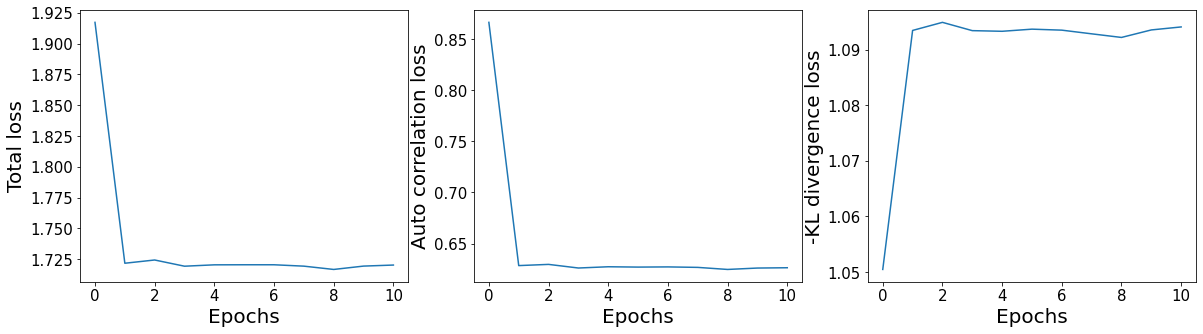

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(20,5))

axs[0].plot(loss_history)
axs[1].plot(torch.load('/content/drive/MyDrive/VDE_1.8_dist/auto_corr_loss.pt'))
axs[2].plot(torch.load('/content/drive/MyDrive/VDE_1.8_dist/kl_D_loss.pt'))
axs[0].set_ylabel('Total loss',fontsize = 20)
axs[1].set_ylabel('Auto correlation loss',fontsize = 20)
axs[2].set_ylabel('-KL divergence loss',fontsize = 20)

for ax in axs.flat:
    ax.tick_params(labelsize = 15)

for ax in axs.flat:
    ax.set_xlabel('Epochs',fontsize = 20)
fig.savefig('Losses in VDE training',dpi = 300)